In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'var_x', 'var_y', 'var_z',
                'med_x', 'med_y', 'med_z',
                'min_x', 'min_y', 'min_z',
                'max_x', 'max_y', 'max_z',
                'pearsonr_xy', 'pearsonr_yz', 'pearsonr_zx',
                'mad_x', 'mad_y', 'mad_z']

target_names = ['Standing', 'Walking normal', 'Jumping', 'Jogging',
                'Sit chair', 'Stairs up', 'Stairs down']
              
'''
def sma_unit(at):
    sum = 0
    for i in at:
        sum = sum + abs(i)
    return sum
'''
def featuresFromBuffer(at):
    feat = np.zeros(30)    # return array float([ 0.,  0.,  0.,  0., ....., 0.])
                            # a vector of 21 features from each window
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
   
    
   # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    # Variance
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
    
    # Range
    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2
    
    # Pearsonr   
    x_pd = pd.Series(x)
    y_pd = pd.Series(y)
    z_pd = pd.Series(z)
    Pearsonr_xy = x_pd.corr(y_pd)
    feat[21] = Pearsonr_xy
    Pearsonr_yz = y_pd.corr(z_pd)
    feat[22] = Pearsonr_yz
    Pearsonr_zx = z_pd.corr(x_pd)
    feat[23] = Pearsonr_zx
    
    # Median Absolute Deviation
    mad = [stats.median_absolute_deviation(i) for i in [x, y, z]]   
    feat[24:27] = mad
    # Interquartile range (khoảng tứ nhị phân)
    iqr = [stats.iqr(i) for i in [x, y, z]]
    feat[27:30] = iqr
    
    return feat  


'''   
    # SMA -> LOWER accuracy
    sma = sma_unit(x)+ sma_unit(y) + sma_unit(z)
    feat[30] = sma
    
     #tilt angel (DATA ko thoa man) do toa do z phai thuoc (-1,1)
    tal = np.arccos(z)
    feat[30] = tal
    
'''     

'\ndef sma_unit(at):\n    sum = 0\n    for i in at:\n        sum = sum + abs(i)\n    return sum\n'

'   \n    # SMA -> LOWER accuracy\n    sma = sma_unit(x)+ sma_unit(y) + sma_unit(z)\n    feat[30] = sma\n    \n     #tilt angel (DATA ko thoa man) do toa do z phai thuoc (-1,1)\n    tal = np.arccos(z)\n    feat[30] = tal\n    \n'

In [2]:
# Import data

dt = pd.read_excel (r'D:\Matlab\orginalData.xlsx')
dt.columns
dt.shape

Index(['Standing', 'Unnamed: 1', 'Unnamed: 2', 'Walking normal', 'Unnamed: 4',
       'Unnamed: 5', 'Jumping', 'Unnamed: 7', 'Unnamed: 8', 'Jogging',
       'Unnamed: 10', 'Unnamed: 11', 'Stairs up', 'Unnamed: 13', 'Unnamed: 14',
       'Stairs down', 'Unnamed: 16', 'Unnamed: 17', 'Sit chair', 'Unnamed: 19',
       'Unnamed: 20', 'Car Step-in', 'Unnamed: 22', 'Unnamed: 23',
       'Car Step-out', 'Unnamed: 25', 'Unnamed: 26', 'Back sitting chair',
       'Unnamed: 28', 'Unnamed: 29', 'Fall front knees lying', 'Unnamed: 31',
       'Unnamed: 32', 'Fall forward lying', 'Unnamed: 34', 'Unnamed: 35',
       'Sideward lying', 'Unnamed: 37', 'Unnamed: 38'],
      dtype='object')

(28939, 39)

In [3]:
Standing = dt[['Standing', 'Unnamed: 1', 'Unnamed: 2']] 
# Delete columns contain missing value (NaN or not value)
Standing = Standing.dropna()
# Create index (start from 1) in first column
Standing.index = pd.RangeIndex(len(Standing.index))
# Drop the first row ((Xoá hàng x,y,z))
Standing = Standing.drop(0)

Walking_normal = dt[['Walking normal', 'Unnamed: 4', 'Unnamed: 5']] 
Walking_normal = Walking_normal.dropna()
Walking_normal.index = pd.RangeIndex(len(Walking_normal.index))
Walking_normal = Walking_normal.drop(0)

Jumping = dt[['Jumping', 'Unnamed: 7', 'Unnamed: 8']] 
Jumping = Jumping.dropna()
Jumping.index = pd.RangeIndex(len(Jumping.index))
Jumping = Jumping.drop(0)

Jogging = dt[['Jogging', 'Unnamed: 10', 'Unnamed: 11']] 
Jogging = Jogging.dropna()
Jogging.index = pd.RangeIndex(len(Jogging.index))
Jogging = Jogging.drop(0)

Stairs_up = dt[['Stairs up', 'Unnamed: 13', 'Unnamed: 14']] 
Stairs_up = Stairs_up.dropna()
Stairs_up.index = pd.RangeIndex(len(Stairs_up.index)) 
Stairs_up = Stairs_up.drop(0)
    
Stairs_down = dt[['Stairs down', 'Unnamed: 16', 'Unnamed: 17']] 
Stairs_down = Stairs_down.dropna()
Stairs_down.index = pd.RangeIndex(len(Stairs_down.index))
Stairs_down = Stairs_down.drop(0)

print (len(Standing))
print (len (Walking_normal))
print (len (Jumping))
print (len (Jogging))
print (len (Stairs_up))
print (len (Stairs_down))


28938
26158
7909
7903
4843
4746


In [4]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 16
stride = 6 #step

# range (start, stop, step)
X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*0.6), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*0.6), len(Standing), stride) 
                                            if i+window_size<=len(Standing)]

X_walk_train = [Walking_normal[i:i+window_size] for i in range(0, int(len(Walking_normal)*0.6), stride)]
X_walk_test = [Walking_normal[i:i+window_size] for i in range(int(len(Walking_normal)*0.6), len(Walking_normal),                                stride) if i+window_size<=len(Walking_normal)]

X_jump_train = [Jumping[i:i+window_size] for i in range(0, int(len(Jumping)*0.6), stride)]
X_jump_test = [Jumping[i:i+window_size] for i in range(int(len(Jumping)*0.6), len(Jumping), stride) 
                                            if i+window_size<=len(Jumping)]

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*0.6), stride)]
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*0.6), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_stairUp_train = [Stairs_up[i:i+window_size] for i in range(0, int(len(Stairs_up)*0.6), stride)] 
X_stairUp_test = [Stairs_up[i:i+window_size] for i in range(int(len(Stairs_up)*0.6), len(Stairs_up), stride) 
                                                if i+window_size<=len(Stairs_up)]

X_stairDown_train = [Stairs_down[i:i+window_size] for i in range(0, int(len(Stairs_down)*0.6), stride)] 
X_stairDown_test = [Stairs_down[i:i+window_size] for i in range(int(len(Stairs_down)*0.6), len(Stairs_down),                                                        stride) if i+window_size<=len(Stairs_down)]

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_jump_train: ', len (X_jump_train))
print ('X_jump_test: ', len (X_jump_test))


print ('X_jog_train: ', len (X_jog_train))
print ('X_jog_test: ', len (X_jog_test))

print ('X_stairUp_train: ', len (X_stairUp_train))
print ('X_stairUp_test: ', len (X_stairUp_test))

print ('X_stairDown_train: ', len (X_stairDown_train))
print ('X_stairDown_test: ', len (X_stairDown_test))




X_stand_train:  2894
X_stand_test:  1927
X_walk_train:  2616
X_walk_test:  1742
X_jump_train:  791
X_jump_test:  525
X_jog_train:  791
X_jog_test:  525
X_stairUp_train:  485
X_stairUp_test:  321
X_stairDown_train:  475
X_stairDown_test:  314


In [5]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_jump_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_stairUp_train:
    train_data.append(acts)
    train_label.append(4)

for acts in X_stairDown_train:
    train_data.append(acts)
    train_label.append(5)

print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_jump_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(3)

for acts in X_stairUp_test:
    test_data.append(acts)
    test_label.append(4)

for acts in X_stairDown_test:
    test_data.append(acts)
    test_label.append(5)


print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  8052
train-label length:  8052
test-data length:  5354
test-label length:  5354


In [6]:
# Tạo mảng features 
train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)


8052

5354

## use selectFomModel

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

### fit model on all training data
from sklearn.ensemble import RandomForestClassifier

model = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
model.fit(train_features, train_label)

### make predictions for test data
predictions = model.predict(test_features)
accuracy = accuracy_score(test_label, predictions)
print(accuracy)

### fit model using each importance as a threshold
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Tầm quan trọng của đặc trưng")
    plt.ylabel("Tên đặc trưng")
    plt.yticks(numpy.arange(c_features), feature_names)
    
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(model, feature_names)
plt.show()

type(model.feature_importances_)
importance = np.asarray(model.feature_importances_)
ip = importance.tolist()
arr = np.array(ip)
thresholds = np.sort(arr)
for thresh in thresholds:
    #select features using threshold
    selection = SelectFromModel(model,threshold = thresh, prefit = True)
    select_X_train = selection.transform(train_features)
    
    #train model
    selection_model = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100)
    selection_model.fit(select_X_train, train_label)
    
    select_X_test = selection.transform(test_features)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(test_label, predictions)
    print ("Thresh = %.3f, n = %d, Accuracy: %.3f%%" % (thresh, select_X_train.shape[1], accuracy))


In [7]:
# beginning of classification:
#https://www.kaggle.com/beagle01/prediction-with-gradient-boosting-classifier
from sklearn.feature_selection import SelectFromModel

print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))


print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree  # Keep file adspy_shared_utilities the same folder to python files

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.972
Accuracy of GBDT classifier on test set: 0.929


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.865
Accuracy of Decision Tree classifier on test set: 0.819


SVM:
Accuracy on training set: 0.97
Accuracy on test set: 0.94


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.946


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.95


In [8]:
print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


y_pred = knn.predict(test_features)
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro')

f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro')



 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.95


0.8854693644346955

0.8781362231544323

0.8933869027416858

0.9495704146432574

0.9495704146432574

0.9495704146432574

6


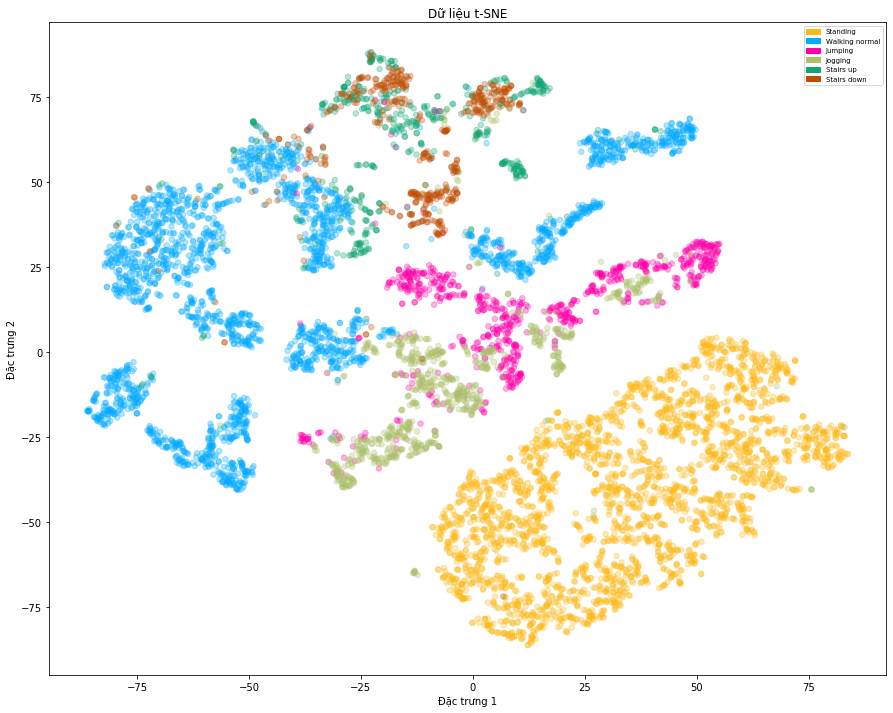

In [9]:
# t-SNE

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels): 
    num_labels = len(class_labels)
    print(num_labels)

    # create a mesh (lưới) to plot the boundaries (đường biên)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   # min & max for feature 1 ((column 0)) 
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   # min & max for feature 2 (column 1)
    

    # marker_shapes = ['v', 's', 'o', '^', '*']
    # Create array color of 7 behaviors
    colors = ['#fdb915', '#00AAFF', '#FF00AA', '#acbf69',# '#ff0000', 
              '#10a674', '#c04e01'] 
    cmap = ListedColormap(colors) 
    
   # Generate a colormap index based on discrete intervals
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(15, 12))  # độ dài row & column của 
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.3, lw=1)
                #edgecolor='black'
    
    # Create array h[] chứa chú thích behaviors & colors tương ứng
    h = []
    for c in range(0, num_labels):
        # tạo chú thích = mpatches.Patch
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') # show ghi chu
    
    plt.xlabel('Đặc trưng 1')
    plt.ylabel('Đặc trưng 2')
    plt.title('Dữ liệu t-SNE')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) # np.array: create array
                                                    # np.uint8: unsigned integer

n_samples = 300
n_components = 2  # dimension
perplexity = 30.0 # number of NEAREST NEIGHBORS that used in other MALIFOLD LEARNING algorithm (value: 5-50)
RS = 1000   

from sklearn.manifold import TSNE
# fit X_visual into embedding space in low-dimensional space and return  array (n_samples, n_components) 
X_tsne = TSNE(random_state=RS, n_components=2, perplexity=30.0, learning_rate=300.0 ).fit_transform(X_visual)
#  , n_components=2, perplexity=30.0, learning_rate=300.0             
plot_labelled_scatter(X_tsne, y_visual,['Standing','Walking normal','Jumping', 'Jogging',
                                        'Stairs up','Stairs down'])


Confusion matrix, without normalization
[[1927    0    0    0    0    0]
 [   0 1724    0    3    5   10]
 [   0    3  494   15    4    9]
 [   0    5   10  497    9    4]
 [   0   17    2    5  232   65]
 [   5   45    1    2   51  210]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.01]
 [0.   0.01 0.94 0.03 0.01 0.02]
 [0.   0.01 0.02 0.95 0.02 0.01]
 [0.   0.05 0.01 0.02 0.72 0.2 ]
 [0.02 0.14 0.   0.01 0.16 0.67]]


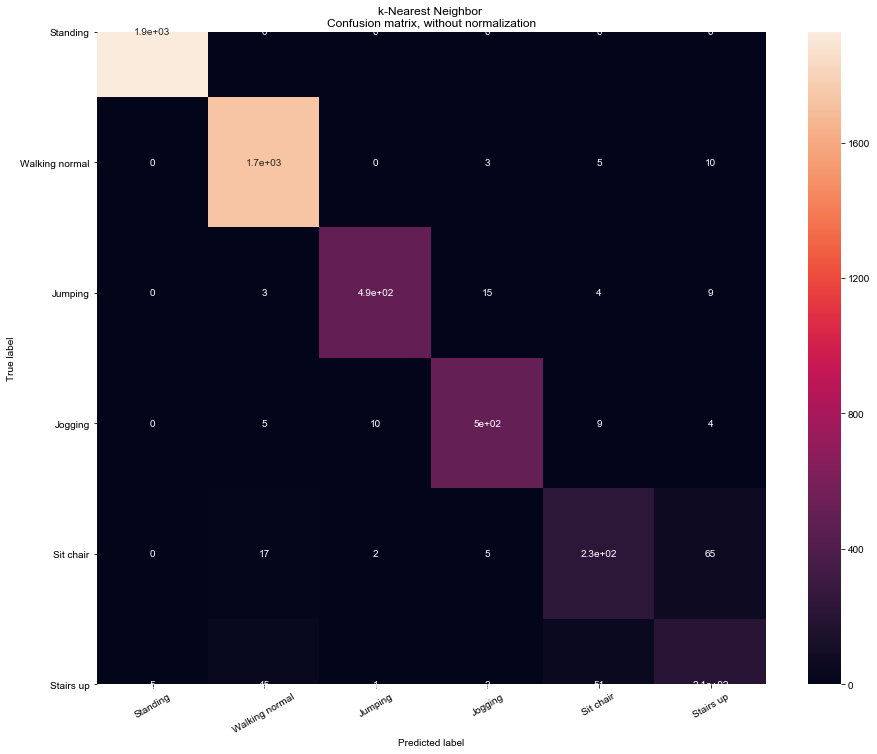

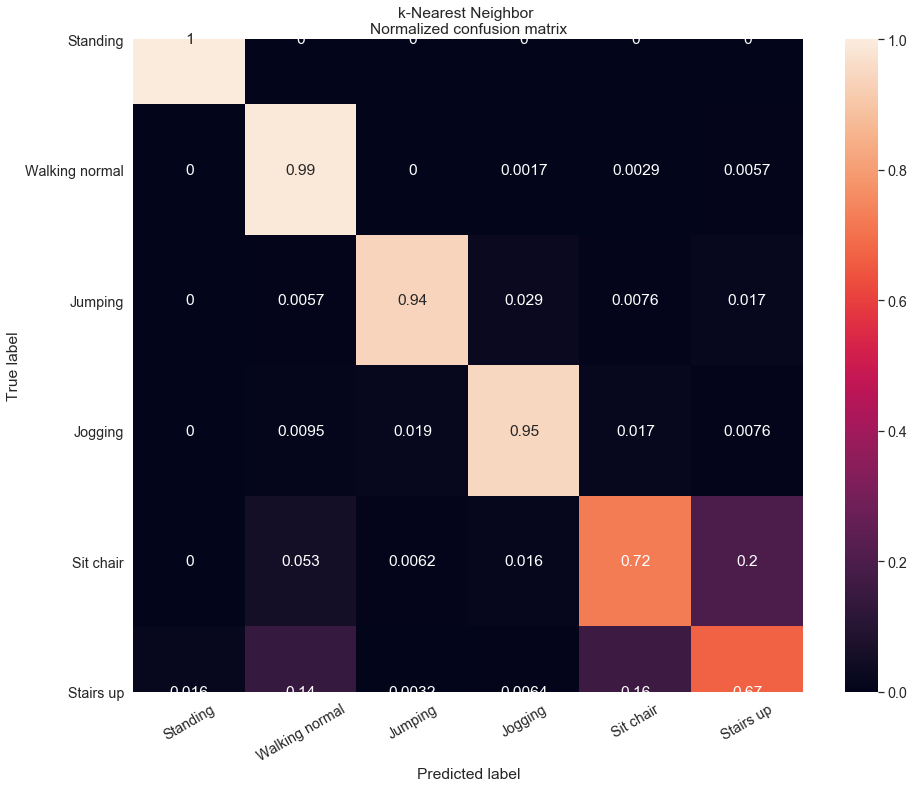


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1927
           1       0.96      0.99      0.98      1742
           2       0.97      0.94      0.96       525
           3       0.95      0.95      0.95       525
           4       0.77      0.72      0.75       321
           5       0.70      0.67      0.69       314

    accuracy                           0.95      5354
   macro avg       0.89      0.88      0.89      5354
weighted avg       0.95      0.95      0.95      5354



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

y_pred = knn.predict(test_features)
lables = np.concatenate([target_names, ])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (15,12))
    #Create a 2-dim array include: rows, columns, data
    dataFrame = pd.DataFrame(cm)
    #create a heatmap, annot = True: add text on each cell over heatmap
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2) #lam tron

plot_confusion_matrix(test_label, y_pred, classes=lables,
        title='k-Nearest Neighbor \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='k-Nearest Neighbor \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred))

<Figure size 800x320 with 0 Axes>

ValueError: shape mismatch: objects cannot be broadcast to a single shape

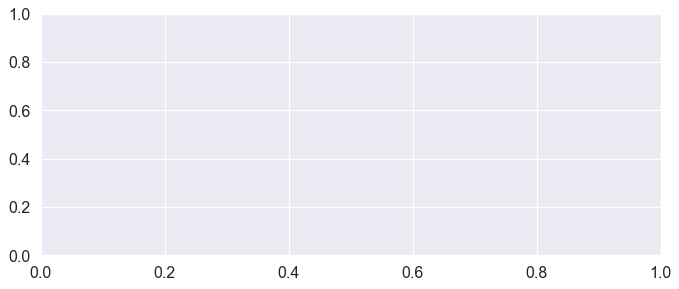

In [11]:
# feature_importances only use with trees classfiers

# adspy_shared_utilities import plot_feature_importances
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Tầm quan trọng của đặc trưng")
    plt.ylabel("Tên đặc trưng")
    plt.yticks(numpy.arange(c_features), feature_names)
    
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf1, feature_names)
plt.show()

print('Feature importances: {}'.format(clf1.feature_importances_))